<a href="https://colab.research.google.com/github/TheNervindraj/DSA-Group-Project-SortLab/blob/master/Stats_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STATS GROUP PROJECT NERVIND, HARID, RIKNESH

In [10]:
#installing library

install.packages("dplyr")
install.packages("janitor")
install.packages("readr")
install.packages("ggplot2")

library(dplyr)
library(janitor)
library(readr)
library(ggplot2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("dplyr"):
“installation of package ‘dplyr’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Rows: 917 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): gender, activity_type, intensity, smoking_status, health_condition
dbl  (17): participant_id, age, height_cm, weight_kg, bmi, duration_minutes,...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Participants with full 7-day data: 131 
# A tibble: 3 × 2
  lifestyle             n
  <chr>             <int>
1 Active               35
2 Moderately Active    69
3 Sedentary            27


participant_id,date,daily_steps,lifestyle,avg_daily_steps,avg_weekday_steps,avg_weekend_steps
<dbl>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
74,2024-01-01,8905,Moderately Active,7150.143,7104,7265.5
74,2024-01-02,6068,Moderately Active,7150.143,7104,7265.5
74,2024-01-03,5978,Moderately Active,7150.143,7104,7265.5
74,2024-01-04,9224,Moderately Active,7150.143,7104,7265.5
74,2024-01-05,5345,Moderately Active,7150.143,7104,7265.5
74,2024-01-06,9370,Moderately Active,7150.143,7104,7265.5


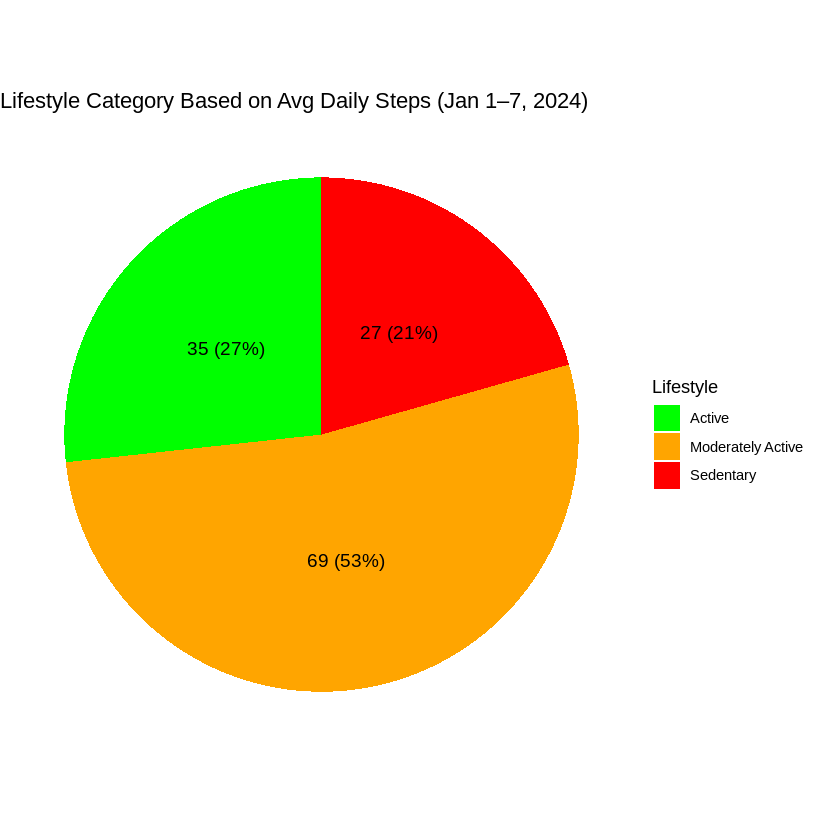

In [11]:
#cleanign dataset

df <- read_csv("/content/modified_health_fitness_dataset_v2.csv")

df <- df %>% clean_names()

df <- df %>% distinct()

df <- df %>%
  filter(!is.na(age), !is.na(height_cm), !is.na(weight_kg))

df$health_condition[is.na(df$health_condition)] <- "Unknown"

df <- df %>%
  mutate(
    date = as.Date(date),
    age = as.integer(age),
    calories_burned = as.numeric(calories_burned),
    daily_steps = as.numeric(daily_steps)
  )

df <- df %>% mutate(across(where(is.character), trimws))

df <- df %>% filter(age > 10 & age < 100, sleep_hours >= 0 & sleep_hours <= 24)

jan_dates <- as.Date("2024-01-01") + 0:6
df_jan <- df %>% filter(date %in% jan_dates)

valid_ids <- df_jan %>%
  group_by(participant_id) %>%
  summarise(n_days = n_distinct(date)) %>%
  filter(n_days == 7) %>%
  pull(participant_id)


df_final <- df_jan %>% filter(participant_id %in% valid_ids)

cat("Participants with full 7-day data:", n_distinct(df_final$participant_id), "\n")

avg_steps_df <- df_final %>%
  group_by(participant_id) %>%
  summarise(avg_daily_steps = mean(daily_steps, na.rm = TRUE))


avg_steps_df <- avg_steps_df %>%
  mutate(lifestyle = case_when(
    avg_daily_steps < 5000 ~ "Sedentary",
    avg_daily_steps < 10000 ~ "Moderately Active",
    avg_daily_steps >= 10000 ~ "Active",
    TRUE ~ "Unknown"
  ))


lifestyle_summary <- avg_steps_df %>%
  count(lifestyle)

print(lifestyle_summary)


#PIE CHART
ggplot(lifestyle_summary, aes(x = "", y = n, fill = lifestyle)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar(theta = "y") +
  labs(
    title = "Lifestyle Category Based on Avg Daily Steps (Jan 1–7, 2024)",
    fill = "Lifestyle"
  ) +
  scale_fill_manual(values = c(
    "Sedentary" = "red",
    "Moderately Active" = "orange",
    "Active" = "green"
  )) +
  theme_void() +
  geom_text(aes(label = paste0(n, " (", round(n / sum(n) * 100), "%)")),
            position = position_stack(vjust = 0.5), size = 4)


df_final <- df_final %>%
  left_join(avg_steps_df, by = "participant_id")

# Add weekday/weekend columns
df_final <- df_final %>%
  mutate(day_of_week = weekdays(date))

# Calculate average weekday and weekend steps
df_final <- df_final %>%
  group_by(participant_id) %>%
  mutate(
    avg_weekday_steps = mean(daily_steps[day_of_week %in% c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday")]),
    avg_weekend_steps = mean(daily_steps[day_of_week %in% c("Saturday", "Sunday")])
  )

head(df_final %>% select(participant_id, date, daily_steps, lifestyle, avg_daily_steps, avg_weekday_steps, avg_weekend_steps))


#NEW FILE
write_csv(df_final, "cleaned_health_fitness_jan1_7_2024.csv")

Rows: 917 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (7): gender, activity_type, intensity, smoking_status, health_conditio...
dbl  (20): participant_id, age, height_cm, weight_kg, bmi, duration_minutes,...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


=== TASK A: One-Sample Z-Test ===
Sample size: 245 
Mean: 13900.07 
Standard Deviation: 2107.42 
Z-score: 28.967 
P-value: 0 
Conclusion: Reject H₀ — Active group significantly exceeds 10,000 steps.


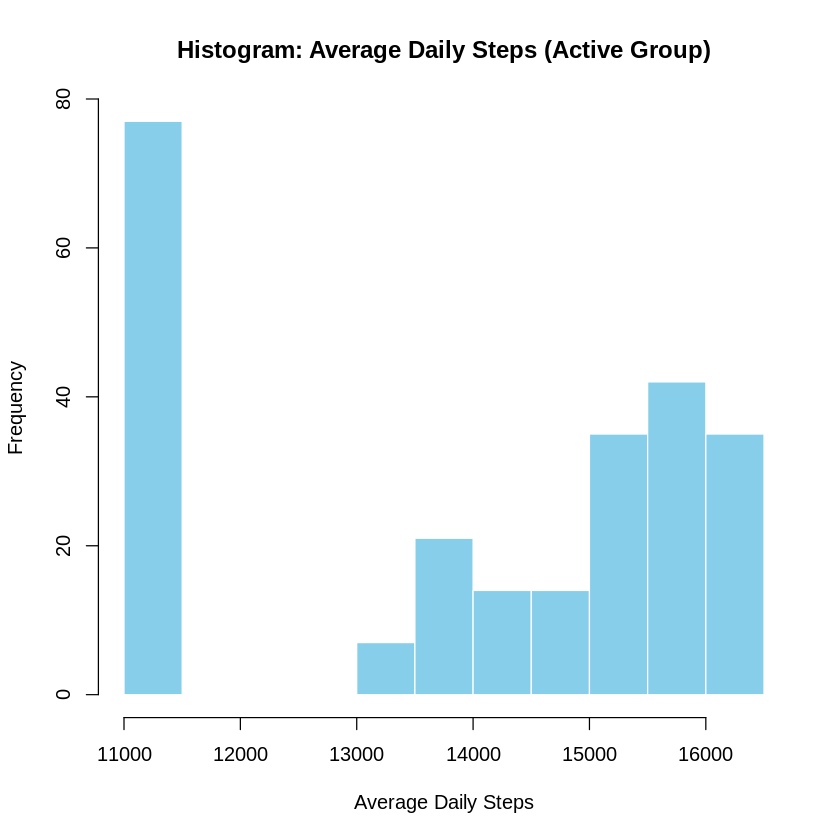

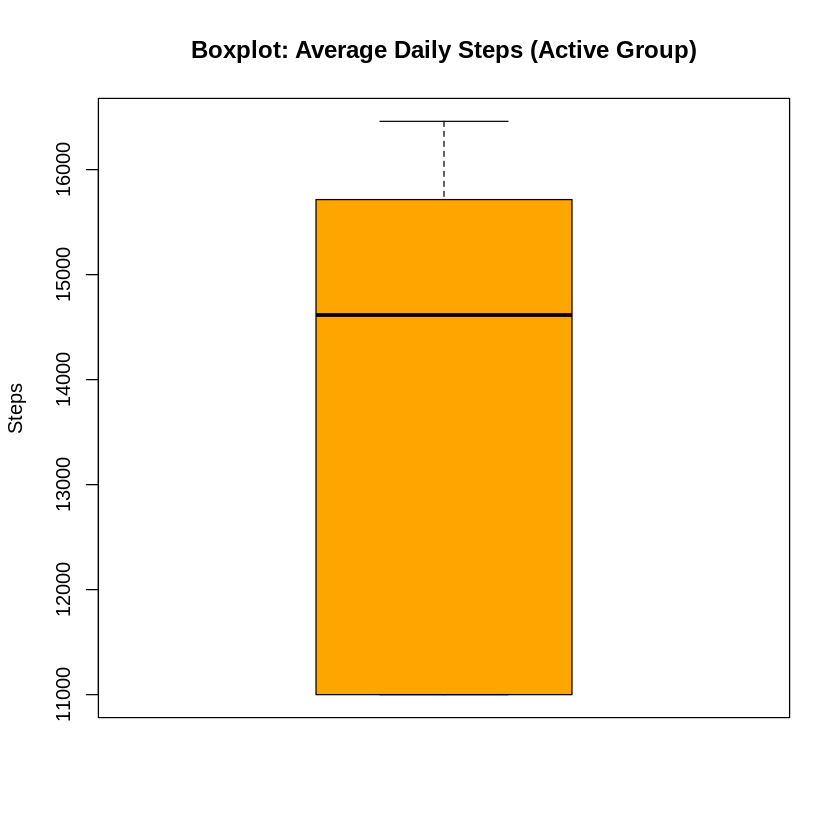

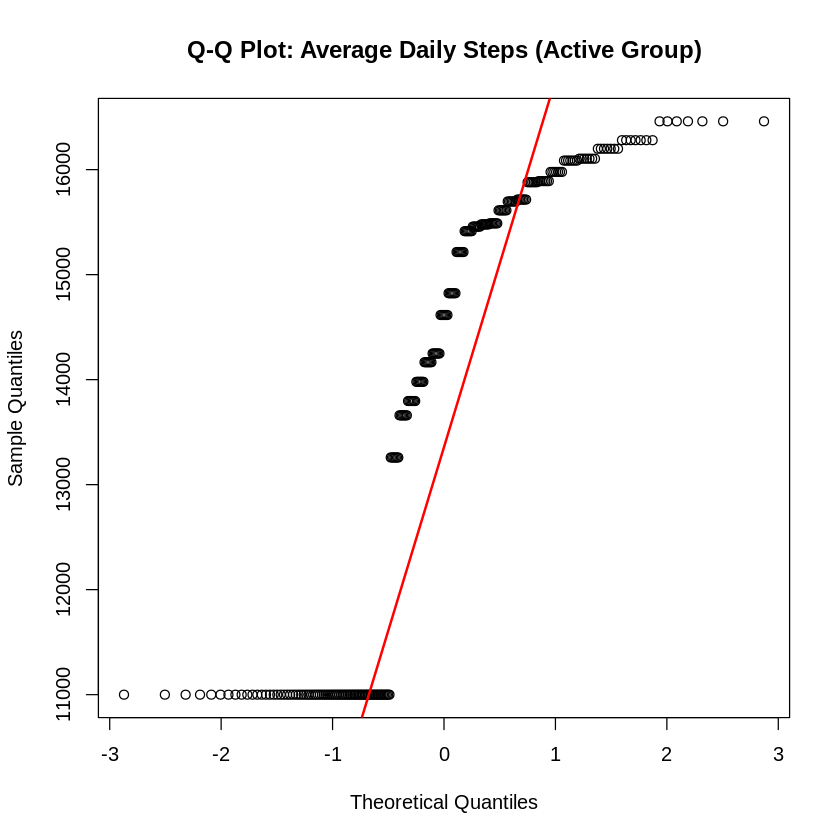

In [12]:
#PHASE 2 & phase 3 TASK a

library(dplyr)
library(readr)


data <- read_csv("cleaned_health_fitness_jan1_7_2024.csv")


active_group <- data %>%
  filter(lifestyle == "Active")

#TASK A: big hypothesis Test:
# H₀: μ = 10000 (average steps is 10,000)
# H₁: μ > 10000 (average steps is greater than 10,000)

#sample
sample_mean <- mean(active_group$avg_daily_steps, na.rm = TRUE)
sample_sd <- sd(active_group$avg_daily_steps, na.rm = TRUE)
n <- nrow(active_group)
mu0 <- 10000

#z-score and p-value
z <- (sample_mean - mu0) / (sample_sd / sqrt(n))
p_value <- 1 - pnorm(z)  # right-tailed test

# Output
cat("=== TASK A: One-Sample Z-Test ===\n")
cat("Sample size:", n, "\n")
cat("Mean:", round(sample_mean, 2), "\n")
cat("Standard Deviation:", round(sample_sd, 2), "\n")
cat("Z-score:", round(z, 3), "\n")
cat("P-value:", round(p_value, 4), "\n")

if (p_value < 0.05) {
  cat("Conclusion: Reject H₀ — Active group significantly exceeds 10,000 steps.\n")
} else {
  cat("Conclusion: Fail to reject H₀ — No significant difference found.\n")
}



hist(active_group$avg_daily_steps,
     main = "Histogram: Average Daily Steps (Active Group)",
     xlab = "Average Daily Steps",
     col = "skyblue",
     border = "white")


boxplot(active_group$avg_daily_steps,
        main = "Boxplot: Average Daily Steps (Active Group)",
        ylab = "Steps",
        col = "orange")


qqnorm(active_group$avg_daily_steps,
       main = "Q-Q Plot: Average Daily Steps (Active Group)")
qqline(active_group$avg_daily_steps, col = "red", lwd = 2)




TASK B; SMALL SAMPLE T-TEST

Rows: 917 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (7): gender, activity_type, intensity, smoking_status, health_conditio...
dbl  (20): participant_id, age, height_cm, weight_kg, bmi, duration_minutes,...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



=== TASK B: Paired t-test (Weekday vs Weekend Steps) ===
t-statistic: 0.849 
Degrees of freedom: 9 
p-value: 0.418 
Confidence interval: [ -544.85 , 1199.19 ]
Mean difference (Weekday - Weekend): 327.17 
Conclusion: Fail to reject H₀ — No significant difference in steps.


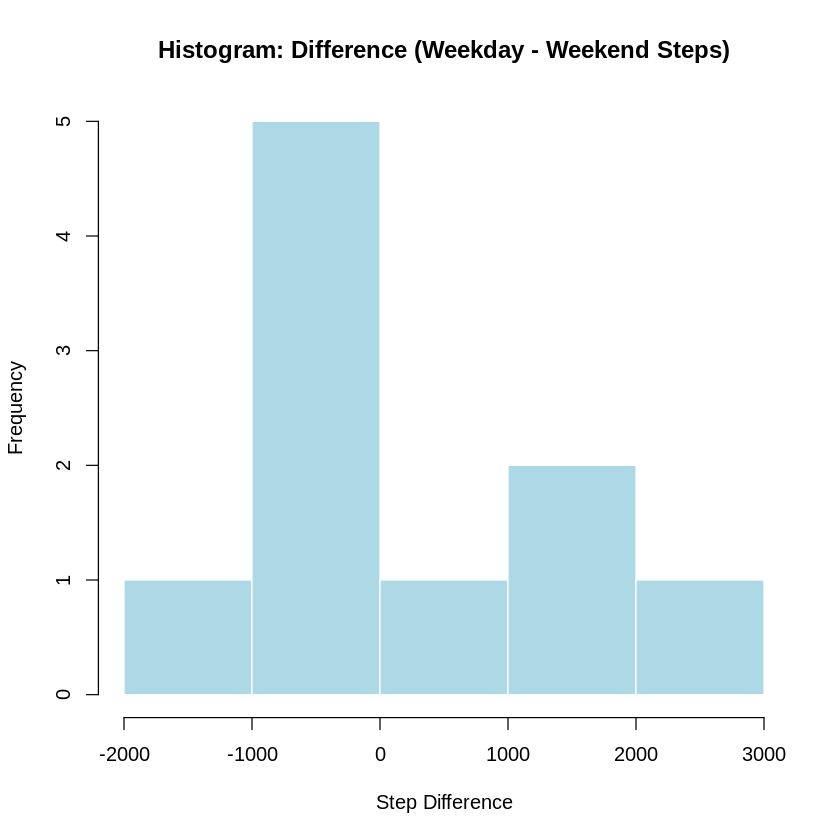

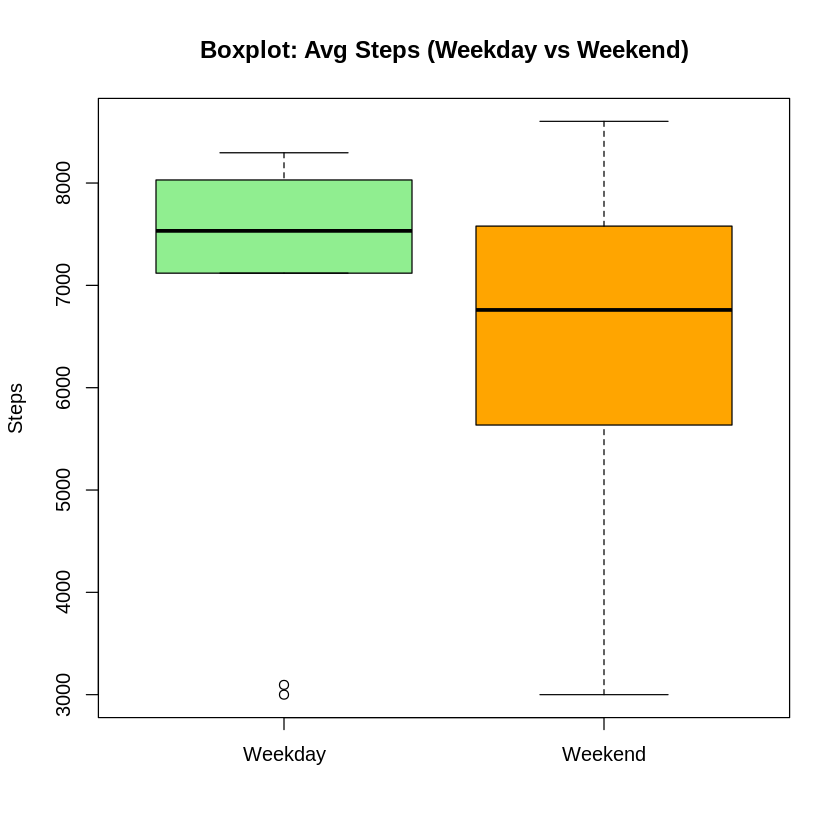

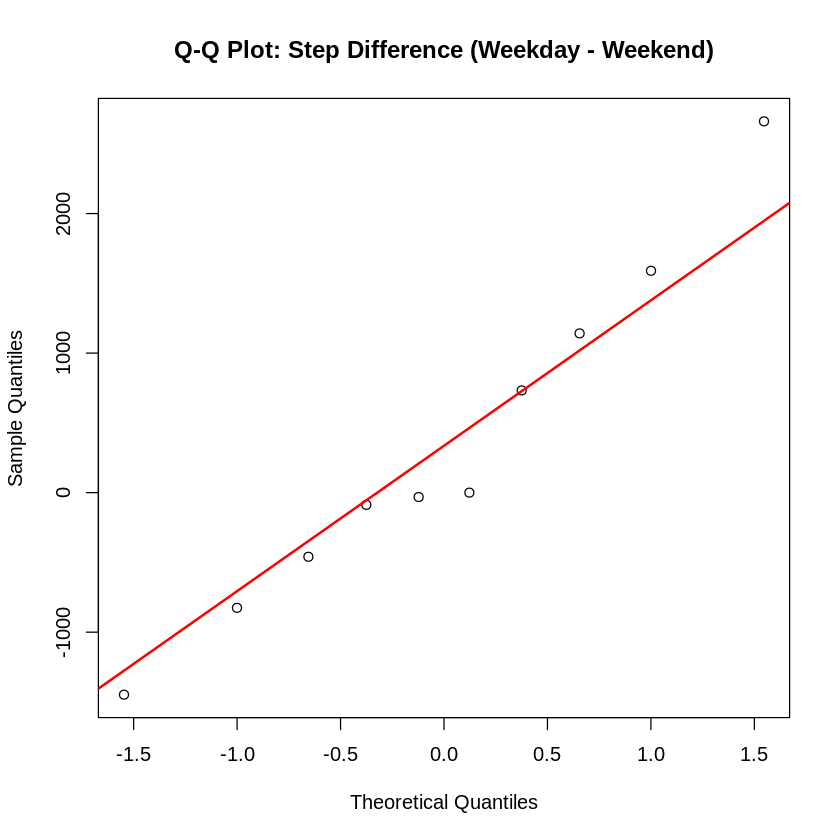

In [13]:
#TASK B: small-sample paired t-test
# H₀: μ_weekday = μ_weekend
# H₁: μ_weekday ≠ μ_weekend

library(readr)
library(dplyr)
library(ggplot2)


data <- read_csv("cleaned_health_fitness_jan1_7_2024.csv")

#Randomly sample 10 participants with both weekday and weekend
set.seed(123)
paired_sample <- data %>%
  filter(!is.na(avg_weekday_steps), !is.na(avg_weekend_steps)) %>%
  sample_n(10)

#Paired t-test
test <- t.test(paired_sample$avg_weekday_steps,
               paired_sample$avg_weekend_steps,
               paired = TRUE)

#Output
cat("\n=== TASK B: Paired t-test (Weekday vs Weekend Steps) ===\n")
cat("t-statistic:", round(test$statistic, 3), "\n")
cat("Degrees of freedom:", test$parameter, "\n")
cat("p-value:", round(test$p.value, 3), "\n")
cat("Confidence interval: [", round(test$conf.int[1], 2), ",", round(test$conf.int[2], 2), "]\n")


mean_diff <- mean(paired_sample$avg_weekday_steps - paired_sample$avg_weekend_steps)
cat("Mean difference (Weekday - Weekend):", round(mean_diff, 2), "\n")


if (test$p.value < 0.05) {
  cat("Conclusion: Reject H₀ — Significant difference between weekday and weekend steps.\n")
} else {
  cat("Conclusion: Fail to reject H₀ — No significant difference in steps.\n")
}


hist(paired_sample$avg_weekday_steps - paired_sample$avg_weekend_steps,
     main = "Histogram: Difference (Weekday - Weekend Steps)",
     xlab = "Step Difference",
     col = "lightblue",
     border = "white")


boxplot(paired_sample$avg_weekday_steps, paired_sample$avg_weekend_steps,
        names = c("Weekday", "Weekend"),
        main = "Boxplot: Avg Steps (Weekday vs Weekend)",
        ylab = "Steps",
        col = c("lightgreen", "orange"))


qqnorm(paired_sample$avg_weekday_steps - paired_sample$avg_weekend_steps,
       main = "Q-Q Plot: Step Difference (Weekday - Weekend)")
qqline(paired_sample$avg_weekday_steps - paired_sample$avg_weekend_steps, col = "red", lwd = 2)



TASK C: INDEPENDANT 2 SAMPLE T TEST

Rows: 917 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (7): gender, activity_type, intensity, smoking_status, health_conditio...
dbl  (20): participant_id, age, height_cm, weight_kg, bmi, duration_minutes,...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



=== TASK C: Independent t-test (Sedentary vs Active Sleep Duration) ===
t-statistic: -0.246 
Degrees of freedom: 405.51 
p-value: 0.806 
Confidence interval: [ -0.21 , 0.16 ]
Sedentary mean: 7.09 
Active mean: 7.06 
Conclusion: Fail to reject H₀ — No significant difference in sleep.


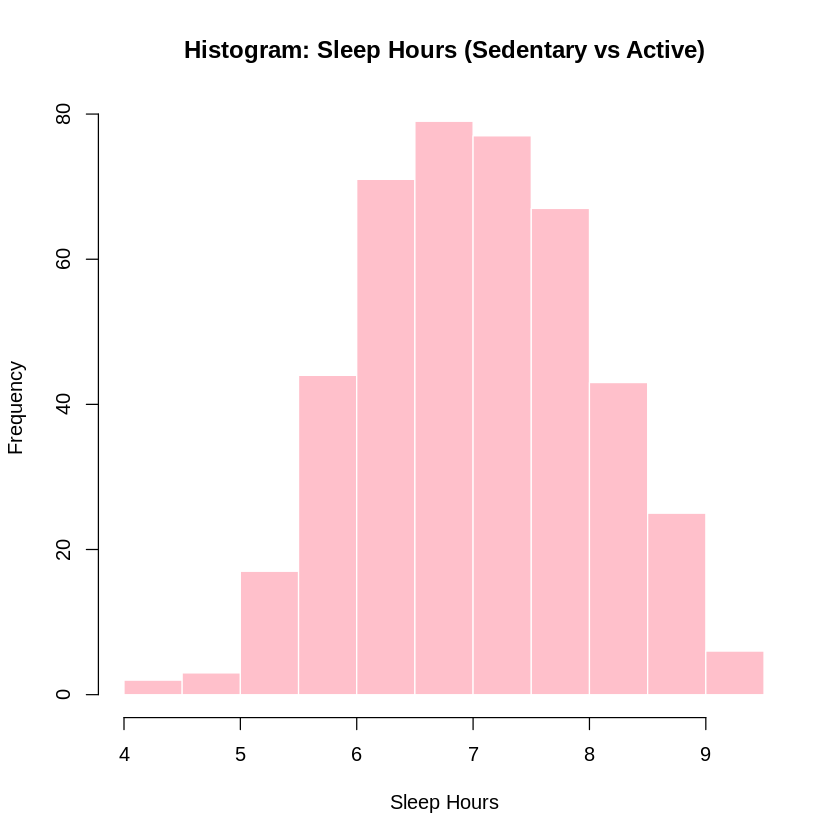

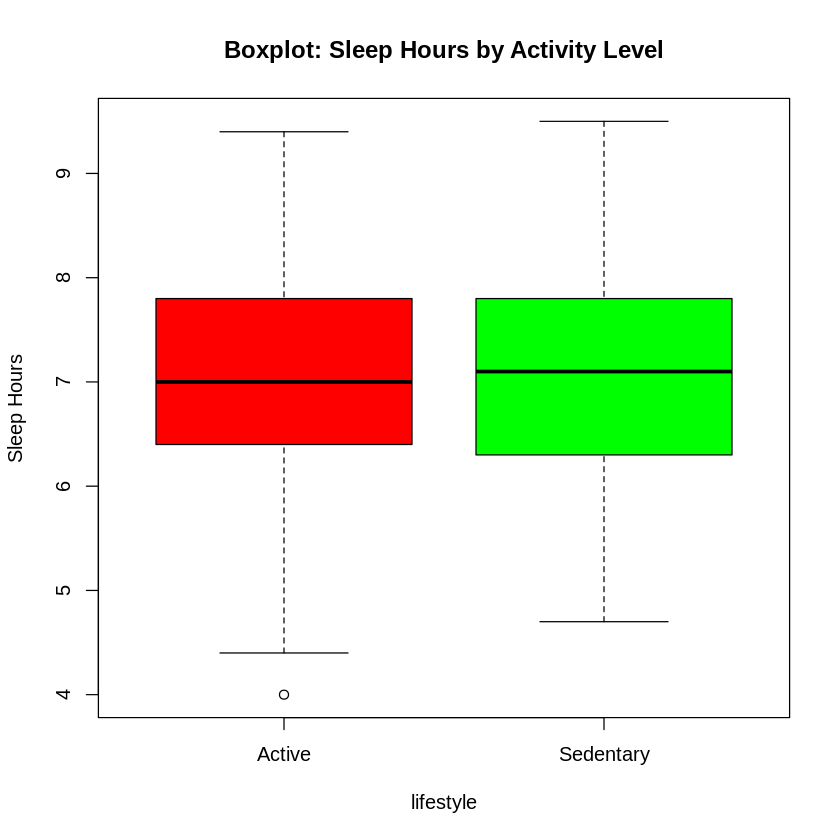

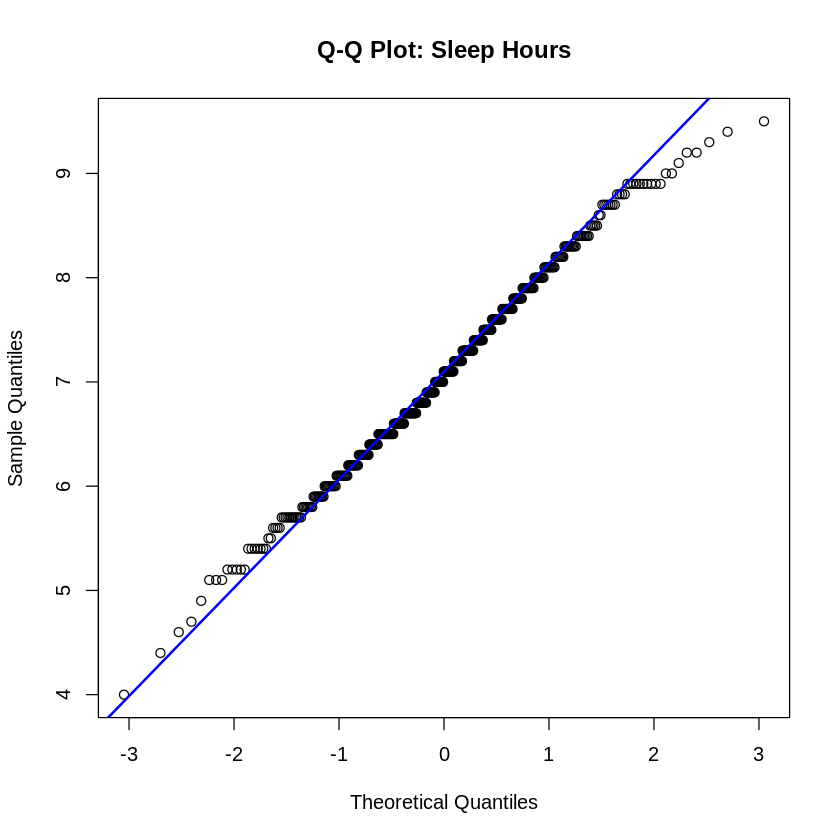

In [14]:
#TASK C: independant 2 sample t-test
# H₀: μ_sedentary = μ_active
# H₁: μ_sedentary ≠ μ_active

# Load libraries
library(dplyr)
library(readr)


data <- read_csv("cleaned_health_fitness_jan1_7_2024.csv")

#Filter for only Sedentary and Active participants
sleep_data <- data %>%
  filter(lifestyle %in% c("Sedentary", "Active"))


sleep_data$lifestyle <- as.factor(sleep_data$lifestyle)


sedentary <- sleep_data %>% filter(lifestyle == "Sedentary")
active <- sleep_data %>% filter(lifestyle == "Active")

#independent two-sample t-test
test <- t.test(sleep_hours ~ lifestyle, data = sleep_data)

# Output
cat("\n=== TASK C: Independent t-test (Sedentary vs Active Sleep Duration) ===\n")
cat("t-statistic:", round(test$statistic, 3), "\n")
cat("Degrees of freedom:", round(test$parameter, 2), "\n")
cat("p-value:", round(test$p.value, 4), "\n")
cat("Confidence interval: [", round(test$conf.int[1], 2), ",", round(test$conf.int[2], 2), "]\n")

# Mean
mean_diff <- mean(sedentary$sleep_hours) - mean(active$sleep_hours)
cat("Sedentary mean:", round(mean(sedentary$sleep_hours), 2), "\n")
cat("Active mean:", round(mean(active$sleep_hours), 2), "\n")


if (test$p.value < 0.05) {
  cat("Conclusion: Reject H₀ — Sleep duration differs significantly.\n")
} else {
  cat("Conclusion: Fail to reject H₀ — No significant difference in sleep.\n")
}

hist(sleep_data$sleep_hours,
     main = "Histogram: Sleep Hours (Sedentary vs Active)",
     xlab = "Sleep Hours",
     col = "pink",
     border = "white")

boxplot(sleep_hours ~ lifestyle, data = sleep_data,
        main = "Boxplot: Sleep Hours by Activity Level",
        ylab = "Sleep Hours",
        col = c("red", "green"))

qqnorm(sleep_data$sleep_hours,
       main = "Q-Q Plot: Sleep Hours")
qqline(sleep_data$sleep_hours, col = "blue", lwd = 2)




TASK D: ANOVA 1 WAY

Rows: 917 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (7): gender, activity_type, intensity, smoking_status, health_conditio...
dbl  (20): participant_id, age, height_cm, weight_kg, bmi, duration_minutes,...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


=== TASK D: One-way ANOVA (Sleep Duration by Activity Group) ===
F-statistic: 0.394 
p-value: 0.6746 
Conclusion: Fail to reject H₀ — No significant difference in mean sleep duration among activity groups.


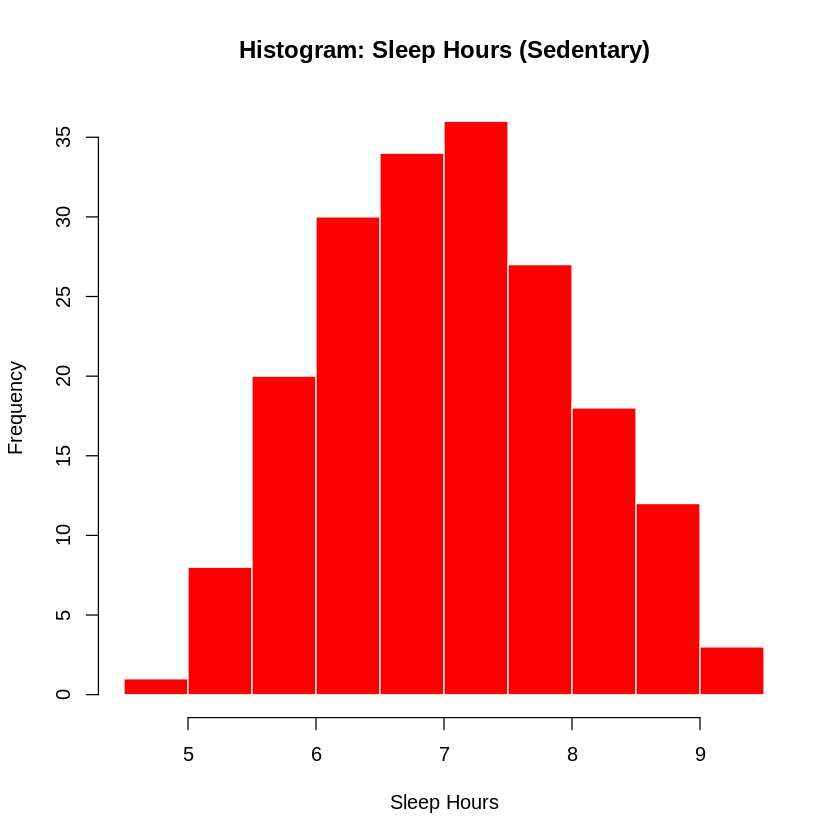

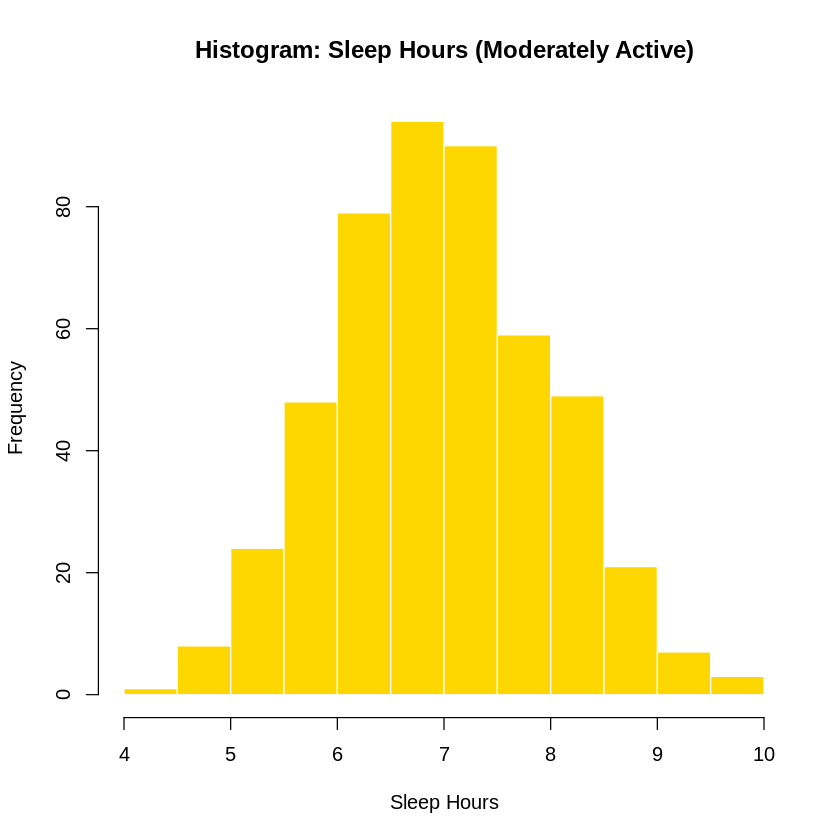

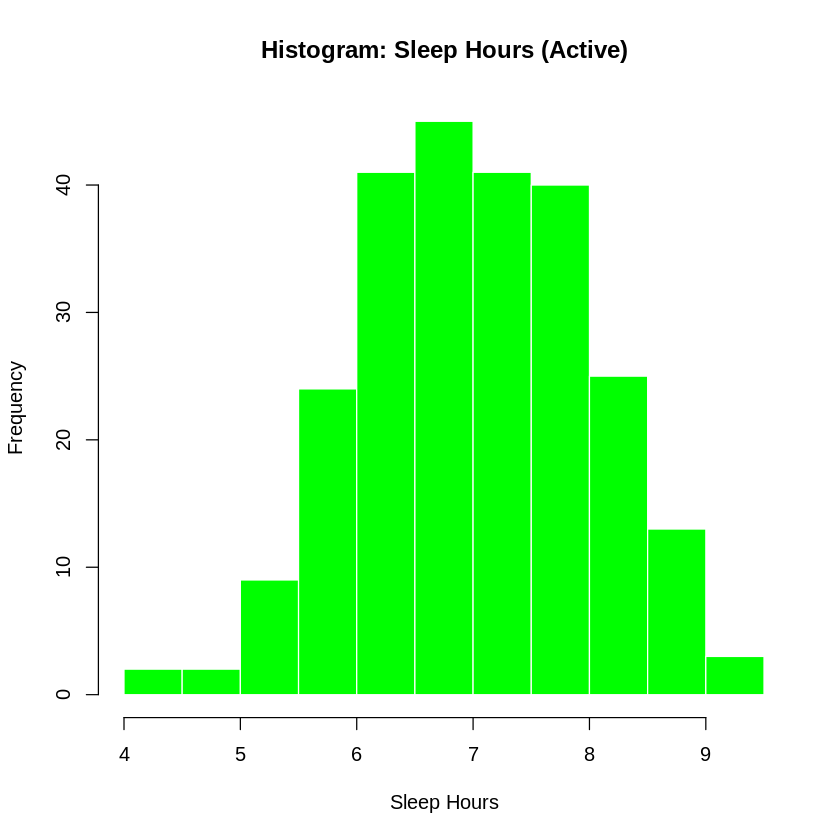

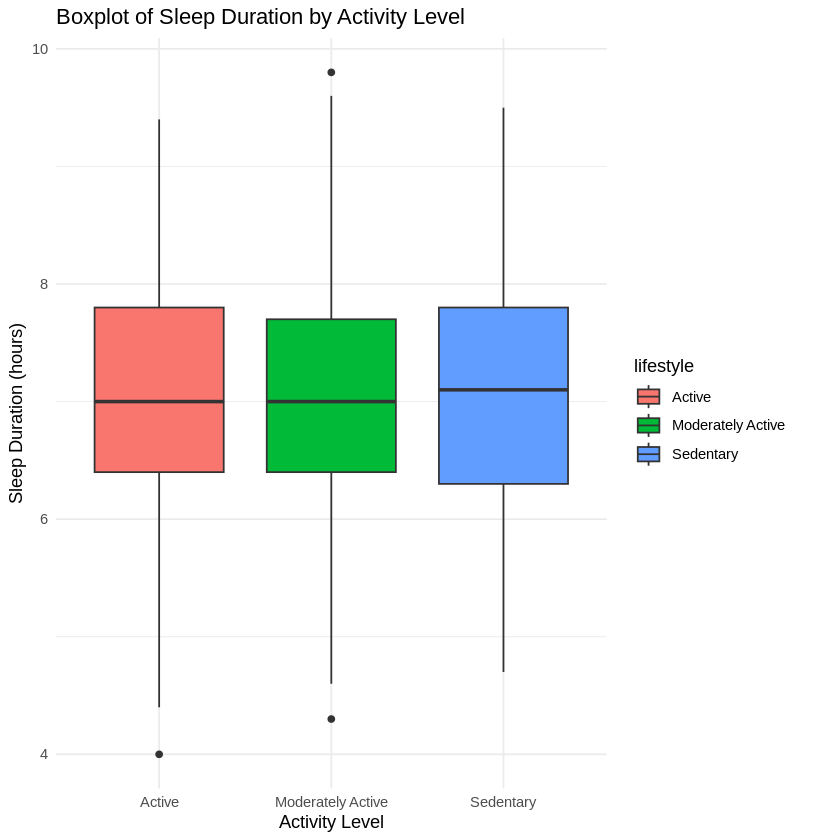

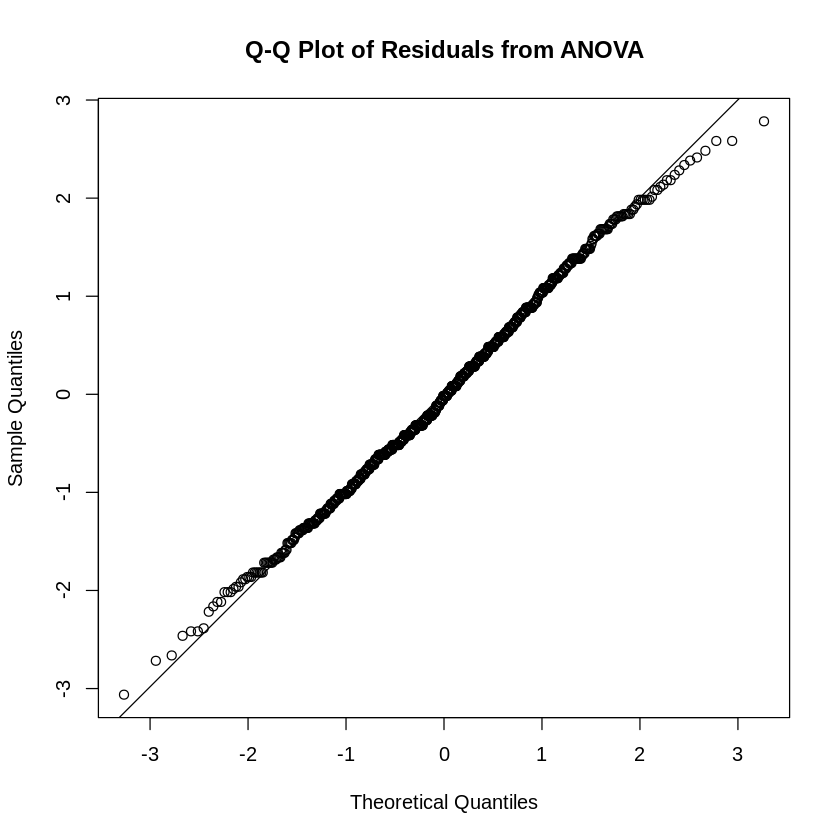

In [15]:
#TASK D: ANOVA 1way
# NULL AND ALTERNATIVE HYPOTHESIS
# H₀: μ_sedentary = μ_moderate = μ_active   → All three groups have the same average sleep quality
# H₁: At least one group mean is different  → At least one group differs in average sleep quality


library(dplyr)
library(readr)
library(ggplot2)


data <- read_csv("cleaned_health_fitness_jan1_7_2024.csv")

anova_result <- aov(sleep_hours ~ lifestyle, data = data)
anova_summary <- summary(anova_result)

f_statistic <- anova_summary[[1]]$`F value`[1]
p_value <- anova_summary[[1]]$`Pr(>F)`[1]

cat("=== TASK D: One-way ANOVA (Sleep Duration by Activity Group) ===\n")
cat("F-statistic:", round(f_statistic, 3), "\n")
cat("p-value:", round(p_value, 4), "\n")

if (p_value < 0.05) {
  cat("Conclusion: Reject H₀ — At least one activity group differs in mean sleep duration.\n")
  tukey_result <- TukeyHSD(anova_result)
  print(tukey_result)
} else {
  cat("Conclusion: Fail to reject H₀ — No significant difference in mean sleep duration among activity groups.\n")
}


hist(data$sleep_hours[data$lifestyle == "Sedentary"],
     main = "Histogram: Sleep Hours (Sedentary)",
     xlab = "Sleep Hours",
     col = "red", border = "white", breaks = 8)

hist(data$sleep_hours[data$lifestyle == "Moderately Active"],
     main = "Histogram: Sleep Hours (Moderately Active)",
     xlab = "Sleep Hours",
     col = "gold", border = "white", breaks = 8)

hist(data$sleep_hours[data$lifestyle == "Active"],
     main = "Histogram: Sleep Hours (Active)",
     xlab = "Sleep Hours",
     col = "green", border = "white", breaks = 8)


ggplot(data, aes(x = lifestyle, y = sleep_hours, fill = lifestyle)) +
  geom_boxplot() +
  labs(title = "Boxplot of Sleep Duration by Activity Level",
       x = "Activity Level", y = "Sleep Duration (hours)") +
  theme_minimal()


qqnorm(anova_result$residuals, main = "Q-Q Plot of Residuals from ANOVA")
qqline(anova_result$residuals)
